# **SENARYO B**

## Imports

In [14]:
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

In [15]:
!apt-get install -y coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [16]:
!apt-get install -y glpk-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Data

In [17]:
# Purpose: Load data from CSV, merge date and time into datetime, sort by datetime, and create a sequential hourly index.
data_path = 'data.csv'
df = pd.read_csv(data_path)  # Read CSV file
df['Datetime'] = pd.to_datetime(df['Tarih'] + ' ' + df['Saat'], dayfirst=True)  # Combine date and time columns
df = df.sort_values('Datetime').reset_index(drop=True)  # Sort by datetime and reset index
df['t'] = range(len(df))  # Create hourly index from 0 to length-1

# Result: DataFrame ready with sorted datetime and a new hourly index column 't'.


In [18]:
df

,Tarih,Saat,Fiyat_(TL/MWh),PV_Üretim_Tahmini_(MWh),Datetime,t
0,01.05.2025,00:00,1499,0.0,2025-05-01 00:00:00,0
1,01.05.2025,01:00,1575,0.0,2025-05-01 01:00:00,1
2,01.05.2025,02:00,1400,0.0,2025-05-01 02:00:00,2
3,01.05.2025,03:00,1400,0.0,2025-05-01 03:00:00,3
4,01.05.2025,04:00,1400,0.7,2025-05-01 04:00:00,4
...,...,...,...,...,...,...
739,31.05.2025,19:00,3390,0.5,2025-05-31 19:00:00,739
740,31.05.2025,20:00,3400,0.0,2025-05-31 20:00:00,740
741,31.05.2025,21:00,3400,0.0,2025-05-31 21:00:00,741
742,31.05.2025,22:00,3080,0.0,2025-05-31 22:00:00,742


## Pyomo Model

### Parameters and Set

In [19]:
# Purpose: Initialize Pyomo model with time set, price parameters, and battery system parameters for optimization.

model = ConcreteModel()

T = len(df)
model.T = RangeSet(0, T - 1)  # Time periods from 0 to T-1

price_dict = df.set_index('t')['Fiyat_(TL/MWh)'].to_dict()
model.price = Param(model.T, initialize=price_dict)  # Electricity price parameter (TL/MWh)

# Battery system parameters
battery_capacity = 10  # MWh, total battery capacity
battery_power = 5      # MW, max charge/discharge power
charge_eff = 0.90      # Charging efficiency
discharge_eff = 0.90   # Discharging efficiency
min_bcl = 0.10 * battery_capacity  # Minimum battery charge level (MWh)
max_bcl = 0.90 * battery_capacity  # Maximum battery charge level (MWh)
initial_energy = 5.0   # Initial battery energy (MWh)
final_energy = 1.0     # Final battery energy (MWh)
usage_cost = 600       # Cost parameter (TL)
grid_capacity = 8      # Maximum grid capacity (MW)

# Result: Model initialized with time index, price parameter, and key battery system constants for further formulation.


### Variables

In [20]:
# Purpose: Define decision variables for battery charging, discharging, and state of charge (SoC) in the model.

model.grid_to_battery = Var(model.T, domain=NonNegativeReals)  # Energy charged to battery from grid (MWh)
model.battery_discharge = Var(model.T, domain=NonNegativeReals)  # Energy discharged from battery to grid (MWh)
model.bcl = Var(model.T, domain=NonNegativeReals)  # Battery charge level (State of Charge) in MWh

# Result: Battery-related decision variables added for modeling charge, discharge, and SoC dynamics.


### Constraints

In [21]:
# Purpose: Define battery charge level dynamics, operational limits, power constraints, and grid capacity constraints.

def bcl_balance_rule(model, t):
    if t == 0:
        return model.bcl[t] == initial_energy + charge_eff * model.grid_to_battery[t] - model.battery_discharge[t] / discharge_eff
    else:
        return model.bcl[t] == model.bcl[t - 1] + charge_eff * model.grid_to_battery[t] - model.battery_discharge[t] / discharge_eff
model.bcl_balance = Constraint(model.T, rule=bcl_balance_rule)  # Battery charge balance over time

def bcl_limits_rule(model, t):
    return (min_bcl, model.bcl[t], max_bcl)
model.bcl_limits = Constraint(model.T, rule=bcl_limits_rule)  # Battery SoC bounds

def charge_power_limit_rule(model, t):
    return model.grid_to_battery[t] <= battery_power
def discharge_power_limit_rule(model, t):
    return model.battery_discharge[t] <= battery_power
model.charge_limit = Constraint(model.T, rule=charge_power_limit_rule)  # Max charge power limit
model.discharge_limit = Constraint(model.T, rule=discharge_power_limit_rule)  # Max discharge power limit

def grid_capacity_rule(model, t):
    return model.grid_to_battery[t] + model.battery_discharge[t] <= grid_capacity
model.grid_capacity_constraint = Constraint(model.T, rule=grid_capacity_rule)  # Grid capacity limit

model.initial_bcl = Constraint(expr=model.bcl[0] == initial_energy)  # Initial battery charge
model.final_bcl = Constraint(expr=model.bcl[T - 1] == final_energy)  # Final battery charge

# Result: Constraints enforce battery energy balance, operational limits, power limits, and grid capacity throughout the time horizon.


### Objective

In [22]:
# Purpose: Define objective to maximize net profit from battery operation considering revenue, charging cost, and usage costs.

def objective_rule(model):
    revenue = sum(model.battery_discharge[t] * model.price[t] for t in model.T)  # Income from battery discharging
    charge_cost = sum(model.grid_to_battery[t] * model.price[t] for t in model.T)  # Cost of charging from grid
    usage_costs = sum(model.battery_discharge[t] * usage_cost for t in model.T)  # Operational usage costs
    return revenue - charge_cost - usage_costs

model.objective = Objective(rule=objective_rule, sense=maximize)

# Result: Objective function maximizes net profit by balancing revenue, grid charging costs, and battery usage costs.


## Solver

In [23]:
# Purpose: Create solver, solve the optimization model, and print solution status and termination condition.

solver = SolverFactory('glpk')  # Define solver (glpk, cbc, gurobi, etc.)

result = solver.solve(model, tee=True)  # Solve model with solver output enabled

# Print solution status and termination condition
print(f"Solution Status: {result.solver.status}")
print(f"Termination Condition: {result.solver.termination_condition}")

# Result: Model solved and solution status information displayed for verification.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpu3jxvy19.glpk.raw --wglp /tmp/tmpv3z9l_li.glpk.glp --cpxlp
 /tmp/tmpffb1z0cp.pyomo.lp
Reading problem data from '/tmp/tmpffb1z0cp.pyomo.lp'...
4466 rows, 2232 columns, 7441 non-zeros
24565 lines were read
Writing problem data to '/tmp/tmpv3z9l_li.glpk.glp'...
19350 lines were written
GLPK Simplex Optimizer 5.0
4466 rows, 2232 columns, 7441 non-zeros
Preprocessing...
1488 rows, 2230 columns, 4460 non-zeros
Scaling...
 A: min|aij| =  9.000e-01  max|aij| =  1.111e+00  ratio =  1.235e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1488
      0: obj =   7.000000000e+03 inf =   4.444e+00 (1)
      1: obj =   3.510000000e+03 inf =   0.000e+00 (0)
*   831: obj =   4.060231000e+05 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 3.4 Mb (3549188 bytes)
Writing basic solution to '/tmp/tmpu3jxvy19.glpk.raw'...
6707 lines we

## Results

In [24]:
# Purpose: Extract solution values for decision variables, calculate financial metrics, and summarize results in a DataFrame.

battery_discharge = [model.battery_discharge[t].value for t in model.T]  # Battery discharge values
grid_to_battery = [model.grid_to_battery[t].value for t in model.T]  # Grid to battery charge values
bcl = [model.bcl[t].value for t in model.T]  # Battery charge levels
prices = [model.price[t] for t in model.T]  # Electricity prices

# Financial calculations
total_usage_cost = sum(d * usage_cost for d in battery_discharge)
total_revenue = sum(d * p for d, p in zip(battery_discharge, prices))
total_charge_cost = sum(c * p for c, p in zip(grid_to_battery, prices))
net_profit = total_revenue - total_charge_cost - total_usage_cost

# Time index combining date and time
time_index = df["Tarih"] + " " + df["Saat"]

# Results DataFrame with hourly values
results_df = pd.DataFrame({
    "Price (TL/MWh)": prices,
    "Grid to Battery Charge (MW)": grid_to_battery,
    "Battery to Grid Discharge (MW)": battery_discharge,
    "Battery State of Charge (MWh)": bcl
}, index=time_index)

# Summary metrics
summary_metrics = {
    "Total Charge Amount (MWh)": sum(grid_to_battery),
    "Total Discharge Amount (MWh)": sum(battery_discharge),
    "Total Battery Usage Cost (TL)": total_usage_cost,
    "Total Charging Cost (TL)": total_charge_cost,
    "Total Revenue (TL)": total_revenue,
    "Net Profit (TL)": net_profit
}

# Print summary metrics
print("\nSummary Metrics:")
for label, value in summary_metrics.items():
    unit = "TL" if "Cost" in label or "Revenue" in label or "Profit" in label else "MWh"
    print(f"{label}: {value:.2f} {unit}")

# Result: Decision variable values and financial summaries are organized and printed for analysis.



Summary Metrics:
Total Charge Amount (MWh): 362.22 MWh
Total Discharge Amount (MWh): 297.00 MWh
Total Battery Usage Cost (TL): 178200.00 TL
Total Charging Cost (TL): 355195.00 TL
Total Revenue (TL): 939418.10 TL
Net Profit (TL): 406023.10 TL


In [25]:
results_df

,Price (TL/MWh),Grid to Battery Charge (MW),Battery to Grid Discharge (MW),Battery State of Charge (MWh)
01.05.2025 00:00,1499,0.0,0.0,5.000000
01.05.2025 01:00,1575,0.0,3.6,1.000000
01.05.2025 02:00,1400,0.0,0.0,1.000000
01.05.2025 03:00,1400,0.0,0.0,1.000000
01.05.2025 04:00,1400,0.0,0.0,1.000000
...,...,...,...,...
31.05.2025 19:00,3390,0.0,0.0,9.000000
31.05.2025 20:00,3400,0.0,5.0,3.444444
31.05.2025 21:00,3400,0.0,2.2,1.000000
31.05.2025 22:00,3080,0.0,0.0,1.000000


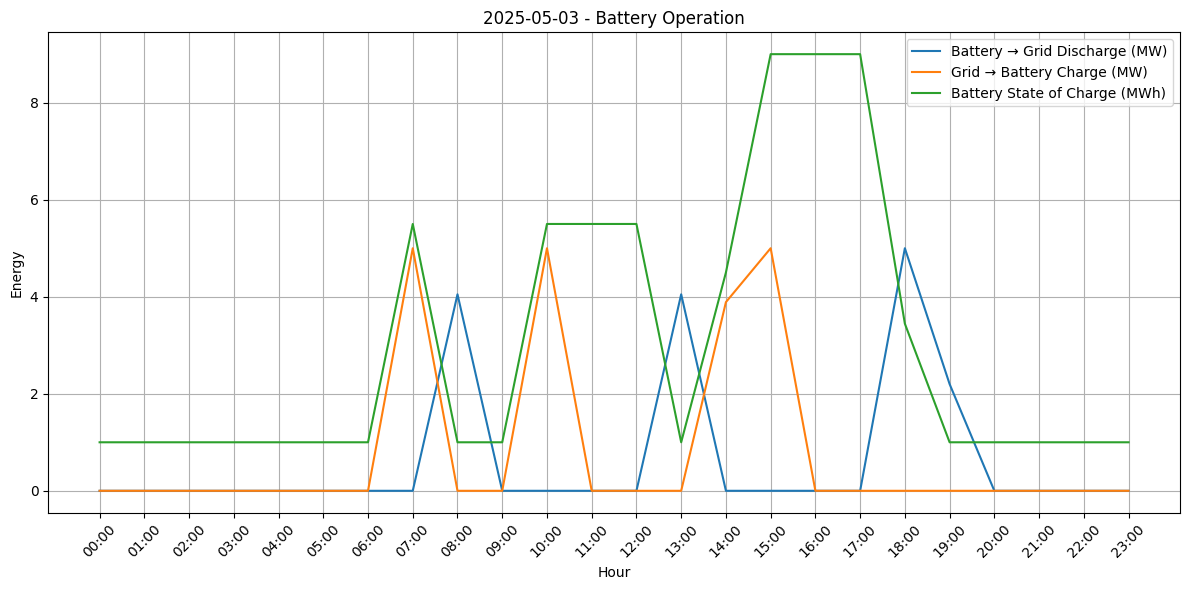

In [26]:
# Purpose: Filter data for a specific day, extract battery operation variables, and plot their hourly profiles.

df["Zaman"] = pd.to_datetime(df["Tarih"] + " " + df["Saat"], dayfirst=True)  # Convert to datetime

target_day = "2025-05-03"
mask = df["Zaman"].dt.date == pd.to_datetime(target_day).date()  # Filter for target day

selected_hours = df[mask].index.tolist()  # Indices of target day hours

selected_discharge = [battery_discharge[t] for t in selected_hours]
selected_charge = [grid_to_battery[t] for t in selected_hours]
selected_bcl = [bcl[t] for t in selected_hours]
selected_time = df.loc[mask, "Zaman"].dt.strftime("%H:%M")  # Format time labels

plt.figure(figsize=(12,6))
plt.plot(selected_time, selected_discharge, label='Battery → Grid Discharge (MW)')
plt.plot(selected_time, selected_charge, label='Grid → Battery Charge (MW)')
plt.plot(selected_time, selected_bcl, label='Battery State of Charge (MWh)')
plt.xlabel('Hour')
plt.ylabel('Energy')
plt.title(f'{target_day} - Battery Operation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Result: Visualization of battery charge, discharge, and state of charge for the selected day.
